In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle

In [2]:
sift = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [3]:
def get_and_crop(img_path):
    try:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_bound = img_path.split('.')[0] + '.txt' # get bounding box
        bound = pd.read_csv(img_bound, sep=' ', header=None).values[0]
        img = img[bound[1]:bound[1] + bound[3], bound[0]:bound[0] + bound[2]]
    except IOError:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # If no bounding box
    finally:
        return img


### Compute and store keypoints and descriptors

In [5]:
for i in range(1,5001):
    img_path = 'ug_data/Images/{:04d}.jpg'.format(i)
    img = get_and_crop(img_path)
    keypoint, descriptor = sift.detectAndCompute(img,None)
    
    #save keypoints
    temp = []
    for point in keypoint:   
        data = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        temp.append(data)
    path = 'ug_data/Keypoints/{:04d}_keypoints.txt'.format(i)
    with open(path, 'wb') as file:
        pickle.dump(temp, file)   
    
    #save descriptors
    path = 'ug_data/Descriptors/{:04d}_descriptors.txt'.format(i)
    with open(path, 'wb') as file:
        pickle.dump(descriptor, file)
        
    print("Image: ", i)

Image:  1
Image:  2
Image:  3
Image:  4
Image:  5
Image:  6
Image:  7
Image:  8
Image:  9
Image:  10
Image:  11
Image:  12
Image:  13
Image:  14
Image:  15
Image:  16
Image:  17
Image:  18
Image:  19
Image:  20
Image:  21
Image:  22
Image:  23
Image:  24
Image:  25
Image:  26
Image:  27
Image:  28
Image:  29
Image:  30
Image:  31
Image:  32
Image:  33
Image:  34
Image:  35
Image:  36
Image:  37
Image:  38
Image:  39
Image:  40
Image:  41
Image:  42
Image:  43
Image:  44
Image:  45
Image:  46
Image:  47
Image:  48
Image:  49
Image:  50
Image:  51
Image:  52
Image:  53
Image:  54
Image:  55
Image:  56
Image:  57
Image:  58
Image:  59
Image:  60
Image:  61
Image:  62
Image:  63
Image:  64
Image:  65
Image:  66
Image:  67
Image:  68
Image:  69
Image:  70
Image:  71
Image:  72
Image:  73
Image:  74
Image:  75
Image:  76
Image:  77
Image:  78
Image:  79
Image:  80
Image:  81
Image:  82
Image:  83
Image:  84
Image:  85
Image:  86
Image:  87
Image:  88
Image:  89
Image:  90
Image:  91
Image:  

### Read descriptors and keypoints from files

In [6]:
def getDescriptor(i):
    path = 'ug_data/Descriptors/{:04d}_descriptors.txt'.format(i)
    file = open(path,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

In [24]:
def getKeypoint(i):
    path = 'ug_data/Keypoints/{:04d}_keypoints.txt'.format(i)
    keypoint = []
    file = open(path,'rb')
    temp = pickle.load(file)
    file.close()
    for point in temp:
        data = cv2.KeyPoint(x=point[0][0],y=point[0][1],size=point[1], angle=point[2], response=point[3], octave=point[4], class_id=point[5])
        keypoint.append(data)
    return keypoint

In [25]:
def calculateSimilarity(i, keyQ, descQ):
    keyI = getKeypoint(i)
    descI = getDescriptor(i)
         
    matches = flann.knnMatch(descQ,descI,k=2)
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)
    #similarity = 100 * (len(good_matches) / min(len(keyQ), len(keyI))) 
    
    if len(good_matches) >= 5:   
        perspectiveQ = np.float32([keyQ[x.queryIdx].pt for x in good_matches]).reshape(-1,1,2)
        perspectiveI = np.float32([keyI[x.trainIdx].pt for x in good_matches]).reshape(-1,1,2)

        _, mask = cv2.findHomography(perspectiveQ, perspectiveI, cv2.RANSAC,5.0)
        res = np.sum(mask.ravel().tolist())
        
    else:
        print("Not enough matches {} out of 5".format(len(good_matches)))
        res = 0
    return res

### Show how Images are matched

Text(0.5, 1.0, 'Image from Database')

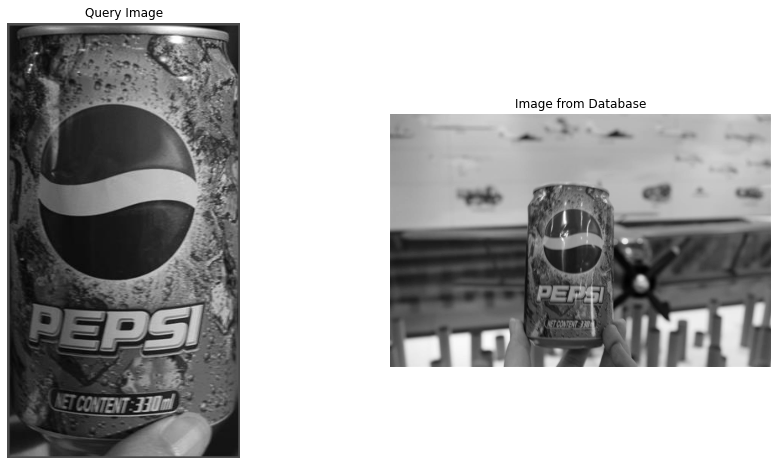

In [109]:
query_path = 'ug_data/examples/example_query/{:02d}.jpg'.format(3)
query = get_and_crop(query_path)
keyQ, descQ = sift.detectAndCompute(query,None)

fig = plt.figure(figsize=(15, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(query, 'gray')
plt.axis('off')
plt.title("Query Image")


img_path = 'ug_data/Images/{:04d}.jpg'.format(4771)
img = get_and_crop(img_path)
keyI, descI = sift.detectAndCompute(img,None)
fig.add_subplot(1, 2, 2)
plt.imshow(img, 'gray')
plt.axis('off')
plt.title("Image from Database")



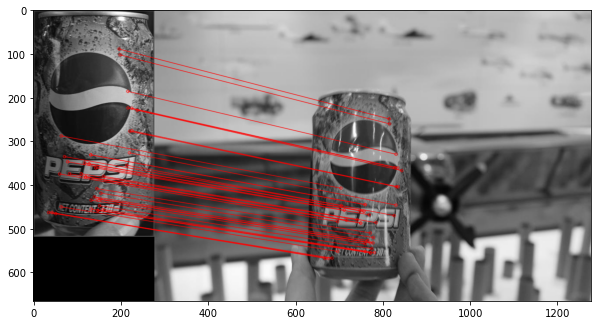

In [108]:
matches = flann.knnMatch(descQ,descI,k=2)
good_matches = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

if len(good_matches) >= 5:   
    perspectiveQ = np.float32([keyQ[x.queryIdx].pt for x in good_matches]).reshape(-1,1,2)
    perspectiveI = np.float32([keyI[x.trainIdx].pt for x in good_matches]).reshape(-1,1,2)

    _, mask = cv2.findHomography(perspectiveQ, perspectiveI, cv2.RANSAC,5.0)

draw_params = dict(matchColor = (255,0,0), 
                   singlePointColor = None,
                   matchesMask = mask.ravel().tolist(), # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(query,keyQ,img,keyI,good_matches,None,**draw_params)

fig = plt.figure(figsize=(10, 6))
plt.imshow(img3, 'gray')


### 

### Train on example query

In [72]:
file = open("rankList.txt", "w")
for i in range(1,11):
    rank_dict = {}
    
    query_path = 'ug_data/examples/example_query/{:02d}.jpg'.format(i)
    query = get_and_crop(query_path)
    keyQ, descQ = sift.detectAndCompute(query,None)
    for j in range(1, 5001):

        res = calculateSimilarity(j, keyQ, descQ)       
        rank_dict['{:04d}'.format(j)] = res
        if j%100 == 0:
            print('Query Image {:02d} : {:04d}.jpg good_matches: {}'.format(i, j, res))
    
    query_res = "Q{}: ".format(i)
    for k, _ in sorted(rank_dict.items(), key=lambda item: item[1], reverse=True):
        query_res += str(int(k)) + " "
    file.write(query_res + "\n")
file.close()

Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough

KeyboardInterrupt: 

### Find Mean average precision score

In [11]:
from __future__ import division
import numpy as np


# average precision
def ave_pre(array):
    ap = 0
    for idx, m in enumerate(array):
        ap_m = (idx + 1) / (m + 1)
        ap+= ap_m
    ap = ap / len(array)
    return ap

# read ground truth num of the relevant images
with open('ug_data/examples/example_result/rank_groundtruth.txt') as f:
    rank_line = f.read().splitlines()
# read retrieved num of the relevant images

with open('rankList.txt') as f:
    rank_result = f.read().splitlines()

# compute mean average precision
ap_sum = 0
for idx, line in enumerate(rank_result):
    line_str = line.split()
    query_num = int(line_str[0][1]) - 1
    result_num = [int(x) for x in line_str[1:]]
    rank_str = rank_line[idx].split()
    rank_gt = [int(x) for x in rank_str[1:]]
    find_idx = []
    for num in rank_gt:
        ind = np.where(np.array(result_num) == num)
        find_idx.extend(ind)
    find_idx = np.array(find_idx).reshape(len(find_idx),)
    find_idx = np.sort(find_idx)
    ap = ave_pre(find_idx)
    print ("Average Precision of Q%d: %.4f"%(idx+1, ap))
    ap_sum = ap_sum + ap
print ("Mean Average Precision: %f" %(ap_sum / len(rank_result)))


Average Precision of Q1: 0.2163
Average Precision of Q2: 0.8608
Average Precision of Q3: 0.9515
Average Precision of Q4: 0.0118
Average Precision of Q5: 0.0416
Average Precision of Q6: 0.9118
Average Precision of Q7: 0.0076
Average Precision of Q8: 0.2138
Average Precision of Q9: 0.0153
Average Precision of Q10: 0.1406
Mean Average Precision: 0.337119


### Top 10 results for sample queries

In [15]:
def get_and_crop_rgb(img_path):
    try:
        img = cv2.imread(img_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_bound = img_path.split('.')[0] + '.txt' # get bounding box
        bound = pd.read_csv(img_bound, sep=' ', header=None).values[0]
        img = img[bound[1]:bound[1] + bound[3], bound[0]:bound[0] + bound[2]]
    except IOError:
        img = cv2.imread(img_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # If no bounding box
    finally:
        return img


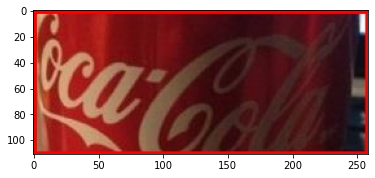

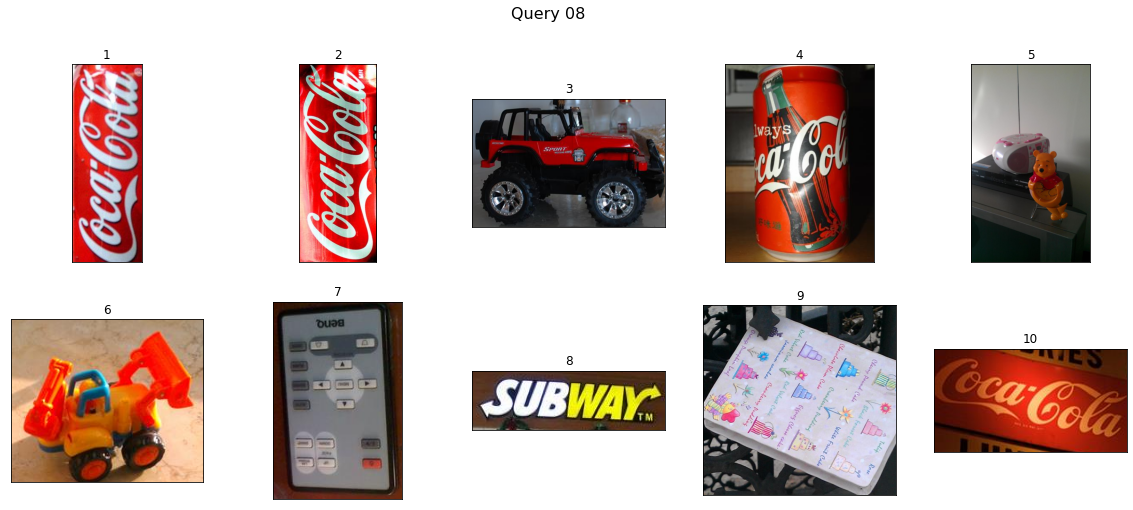

In [21]:
with open('rankList.txt') as f:
    rank_result = f.read().splitlines()
k=7
line_str = rank_result[k].split()
result_num = [int(x) for x in line_str[1:]]

query_path = 'ug_data/examples/example_query/{:02d}.jpg'.format(k+1)
query = cv2.cvtColor(get_and_crop_rgb(query_path), cv2.COLOR_BGR2RGB)
plt.imshow(query)

fig, axs = plt.subplots(2, 5, figsize=(20, 8), facecolor='w', edgecolor='w')
fig.suptitle('Query {:02d} '.format(k+1), fontsize=16)
axs = axs.ravel()
for i in range(10):
    
   
    imgfile = 'ug_data/Images/{:04d}.jpg'.format(result_num[i])
    matched_img = cv2.cvtColor(get_and_crop_rgb(imgfile), cv2.COLOR_BGR2RGB)
    axs[i].imshow(matched_img)
    axs[i].set_title(str(str(i+1)))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

### Getting results for main query images

In [12]:
file = open("rankList_main.txt", "w")
for i in range(1,21):
    rank_dict = {}
    
    query_path = 'ug_data/Queries/{:02d}.jpg'.format(i)
    query = get_and_crop(query_path)
    keyQ, descQ = sift.detectAndCompute(query,None)
    for j in range(1, 5001):

        res = calculateSimilarity(j, keyQ, descQ)       
        rank_dict['{:04d}'.format(j)] = res
        if j%100 == 0:
            print('Query Image {:02d} : {:04d}.jpg good_matches: {}'.format(i, j, res))
    
    query_res = "Q{}: ".format(i)
    for k, _ in sorted(rank_dict.items(), key=lambda item: item[1], reverse=True):
        query_res += str(int(k)) + " "
    file.write(query_res + "\n")
file.close()

Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Query Image 01 : 0600.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 

Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Query Image 01 : 2200.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 

Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Query Image 01 : 2700.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 

Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Query Image 01 : 3200.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 4 out of 

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Query Image 02 : 0500.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Query Imag

Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Query Image 02 : 1800.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 

Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Query Image 02 : 2200.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 

Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Query Image 02 : 2600.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 

Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Query Image 02 : 3000.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 

Not enough matches 1 out of 5
Query Image 02 : 3400.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 

Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Query Image 03 : 0100.jpg good_matches: 4
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Query Image 03 : 0200.jpg good_matches: 4
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough match

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Query Image 03 : 1600.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 3 out of 5
Query Image 03 : 2800.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Query Image 03 : 2900.jpg good_matches: 4
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough match

Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Query Image 03 : 4000.jpg good_matches: 4
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 

Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Query Image 04 : 0100.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 

Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Query Image 04 : 0800.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 

Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Query Image 04 : 1500.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 

Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Query Image 04 : 2700.jpg good_matches: 

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Query Image 04 : 4200.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Query Image 04 : 4700.jpg good_matches: 0
Not enough matches 4 out of 

Not enough matches 4 out of 5
Not enough matches 3 out of 5
Query Image 05 : 1100.jpg good_matches: 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Query Image 05 : 1200.jpg good_matches: 4
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Query Image 05 : 1300.jpg good_matches: 4
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Query Image 05 : 1400.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Query Image 05 : 1500.jpg good_matches: 4
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Query Image 05 : 1600.jpg good_matches: 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 

Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Query Image 05 : 4900.jpg good_matches: 7
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Query Image 05 : 5000.jpg good_matches: 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough match

Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Query Image 06 : 1400.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Query Image 06 : 2200.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 0 out of 5
Query Image 06 : 2700.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 

Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Query Image 06 : 3300.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Query Image 06 : 3900.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 

Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Query Image 06 : 4400.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 

Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Query Image 06 : 5000.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Query Image 07 : 0100.jpg good_matches: 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough match

Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Query Image 07 : 2300.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Query Image 07 : 2400.jpg good_matches: 6
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Query Image 07 : 2500.jpg good_matches: 4
Not 

Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Query Image 07 : 4500.jpg good_matches: 6
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Query Image 07 : 4600.jpg good_matches: 4
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough match

Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Query Image 08 : 0300.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 

Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Query Image 08 : 1300.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 

Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Query Imag

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Query Image 08 : 2300.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Query Image 08 : 2600.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 

Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Query Image 08 : 2900.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 

Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Query Image 08 : 3500.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Query Image 08 : 3800.jpg good_matches: 4
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 

Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Query Image 08 : 4100.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Query Image 08 : 4400.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 

Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Query Image 08 : 4700.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 

Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Query Image 09 : 1200.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 

Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Query Image 09 : 2400.jpg good_matches: 4
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 

Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Query Image 09 : 3700.jpg good_matches: 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 

Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Query Image 09 : 4800.jpg good_matches: 4
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Query Image 09 : 4900.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough match

Not enough matches 2 out of 5
Query Image 10 : 1400.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Query Image 10 : 1500.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough match

Not enough matches 3 out of 5
Query Image 10 : 2900.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Query Image 10 : 3000.jpg good_matches: 8
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough match

Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Query Image 10 : 4400.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Query Image 10 : 4500.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough match

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Query Image 11 : 0200.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 

Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Query Image 11 : 1900.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 

Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Query Image 11 : 2200.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Query Image 11 : 2500.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Query Image 12 : 0300.jpg good_matches: 0
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 

Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Query Image 12 : 1600.jpg good_matches: 0
Not enough matches 0 out of 

Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Query Image 12 : 1900.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 

Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Query Image 12 : 2200.jpg good_matches: 0
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Query Image 13 : 2300.jpg good_matches: 0
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Query Image 13 : 2600.jpg good_matches: 0
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Query Image 13 : 3700.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 

Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Query Image 13 : 4000.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Query Image 14 : 0500.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Query Image 14 : 1200.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 

Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Query Image 14 : 1900.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Query Image 14 : 2900.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 4 out of 5
Query Image 14 : 3200.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 

Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Query Image 15 : 0200.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Query Image 15 : 0600.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 

Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Query Image 15 : 1700.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Query Image 15 : 2400.jpg good_matches: 0
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 

Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Query Image 15 : 3100.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 

Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Query Imag

Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 2 out of 5
Query Image 16 : 2300.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 

Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Query Image 16 : 3700.jpg good_matches: 7
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 

Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Query Image 16 : 4600.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 

Not enough matches 3 out of 5
Query Image 17 : 0500.jpg good_matches: 6
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Query Image 17 : 0600.jpg good_matches: 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Query Image 17 : 0700.jpg good_matches: 4
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Query Image 17 : 0800.jpg good_matches: 8
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Query Image 17 : 0900.jpg good_matches: 7
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Query Image 17 : 1000.jpg good_matches: 5
Not enough matches 2 out of 

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Query Image 18 : 0300.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 

Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Query Image 18 : 0600.jpg good_matches: 0
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Query Image 18 : 1700.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Query Image 18 : 2000.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Query Image 18 : 2800.jpg good_matches: 0
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Query Image 18 : 3100.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 

Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Query Image 18 : 4200.jpg good_matches: 0
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Query Image 18 : 5000.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Query Image 19 : 0700.jpg good_matches: 7
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Query Image 19 : 1400.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 

Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Query Image 19 : 2700.jpg good_matches: 0
Not enough matches 3 out of 5
Not enough matches 4 out of 

Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 4 out of 5
Query Image 19 : 5000.jpg good_matches: 0
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Query Image 20 : 0500.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Query Image 20 : 0900.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough

Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Query Image 20 : 1800.jpg good_matches: 0
Not enough matches 1 out of 

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Query Image 20 : 2900.jpg good_matches: 0
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 

Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Query Image 20 : 3300.jpg good_matches: 0
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 

Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough

Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Not enough matches 2 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough

Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 0 out of 5
Query Image 20 : 4400.jpg good_matches: 0
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 4 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 0 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 3 out of 5
Not enough matches 3 out of 5
Not enough matches 1 out of 5
Not enough matches 1 out of 5
Not enough matches 2 out of 5
Not enough matches 3 out of 5
Not enough matches 4 out of 5
Not enough matches 1 out of 